# Разведывательный анализ данных (EDA)

In [1]:
# импорт библиотек
import json 
import glob 
import pandas as pd 
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots 

import scipy
from scipy.stats import shapiro
from scipy.stats import normaltest
import scipy.stats as stats

from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
import category_encoders as ce 
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import optuna
import pickle
import joblib

In [2]:
# загрузим предобработанный файл
df_clean = pd.read_csv('data/df_clean.csv')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541567 entries, 0 to 541566
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regionName          541567 non-null  object 
 1   age_org             541567 non-null  float64
 2   hasRegionalSupport  541567 non-null  int64  
 3   mainOkved_name      541567 non-null  object 
 4   addOkved            541567 non-null  int64  
 5   addOkved_bool       541567 non-null  int64  
 6   opf_group           541567 non-null  object 
 7   socialMedia         541567 non-null  int64  
 8   reports             541567 non-null  int64  
 9   gos_help_count      541567 non-null  int64  
 10  incomeTotal         541567 non-null  float64
 11  target              541567 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 49.6+ MB


In [3]:
# описательные статистики для числовых переменных
df_clean.describe()

,age_org,hasRegionalSupport,addOkved,addOkved_bool,socialMedia,reports,gos_help_count,incomeTotal,target
count,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,5.415670e+05,541567.000000
mean,12.062499,0.020221,2.921197,0.503044,0.000011,0.238157,0.768136,5.446457e+06,0.061318
std,9.568003,0.140755,7.933588,0.499991,0.003328,0.425956,14.636437,8.745437e+08,0.239914
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,9.300000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,18.100000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
max,79.200000,1.000000,526.000000,1.000000,1.000000,1.000000,2538.000000,3.494067e+11,1.000000


In [4]:
# описательные статистики для категориальных переменных
df_clean.describe(include=['object'])

,regionName,mainOkved_name,opf_group
count,541567,541567,541567
unique,86,1921,14
top,Москва,"Деятельность прочих общественных организаций, ...",Общественная организация
freq,56421,100573,106890


## Визуализация и анализ данных

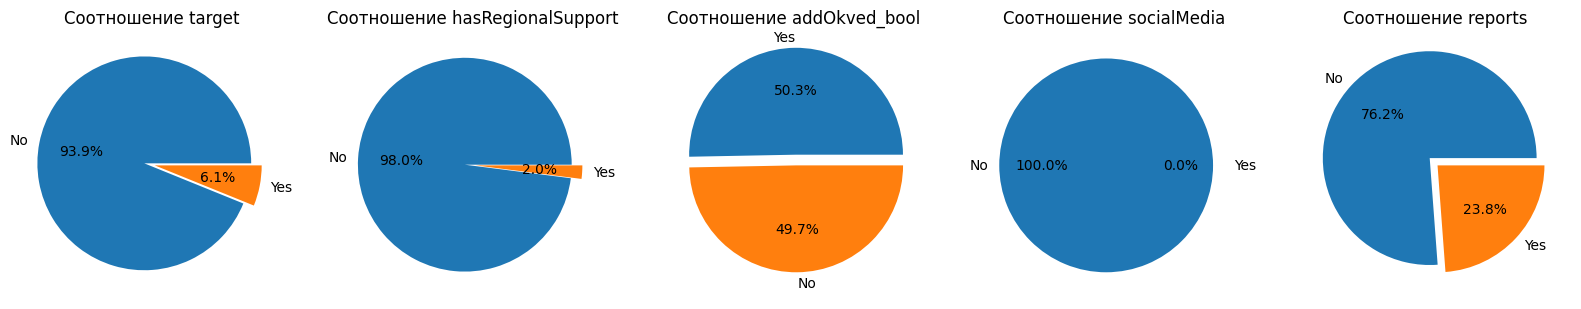

In [5]:
# построим круговые диаграммы для бинарных признаков

# выделяем имена признаков 
features = ['target', 'hasRegionalSupport', 'addOkved_bool', 'socialMedia', 'reports']
n = len(features) 
fig, axes = plt.subplots(1, n, figsize=(20, 10)) 

# создаем цикл для всех признаков из списка 
for i, feature in enumerate(features): 
    #строим диаграмму
    axes[i].pie(
        df_clean[feature].value_counts(normalize=True)*100,
        labels=(df_clean[feature].value_counts(normalize=True)*100).rename({0: 'No', 1: 'Yes'}, axis='index').index,
        autopct='%.1f%%',
        explode = [0.1, 0]
    )
    axes[i].set_title('Соотношение {} '.format(feature), fontsize=12);

Всего 6% НКО получили госфинансирование, 2% - региональную поддержку в качестве СО НКО. Чуть больше половины НКО имеют дополнительный ОКВЭД, почти четверть НКО сдали отчеты в Минюст РФ, меньше 1% НКО имеют сведения об учетных записях в соцсетях. 
По отчетам скорей всего данные неполные, т.к. согласно законодательству РФ все некоммерческие организации обязаны представлять отчетность в Минюст России один раз в год. 
Также очень мало сведений об учетных записях в соцсетях, возможно данные заполнены не полностью. 

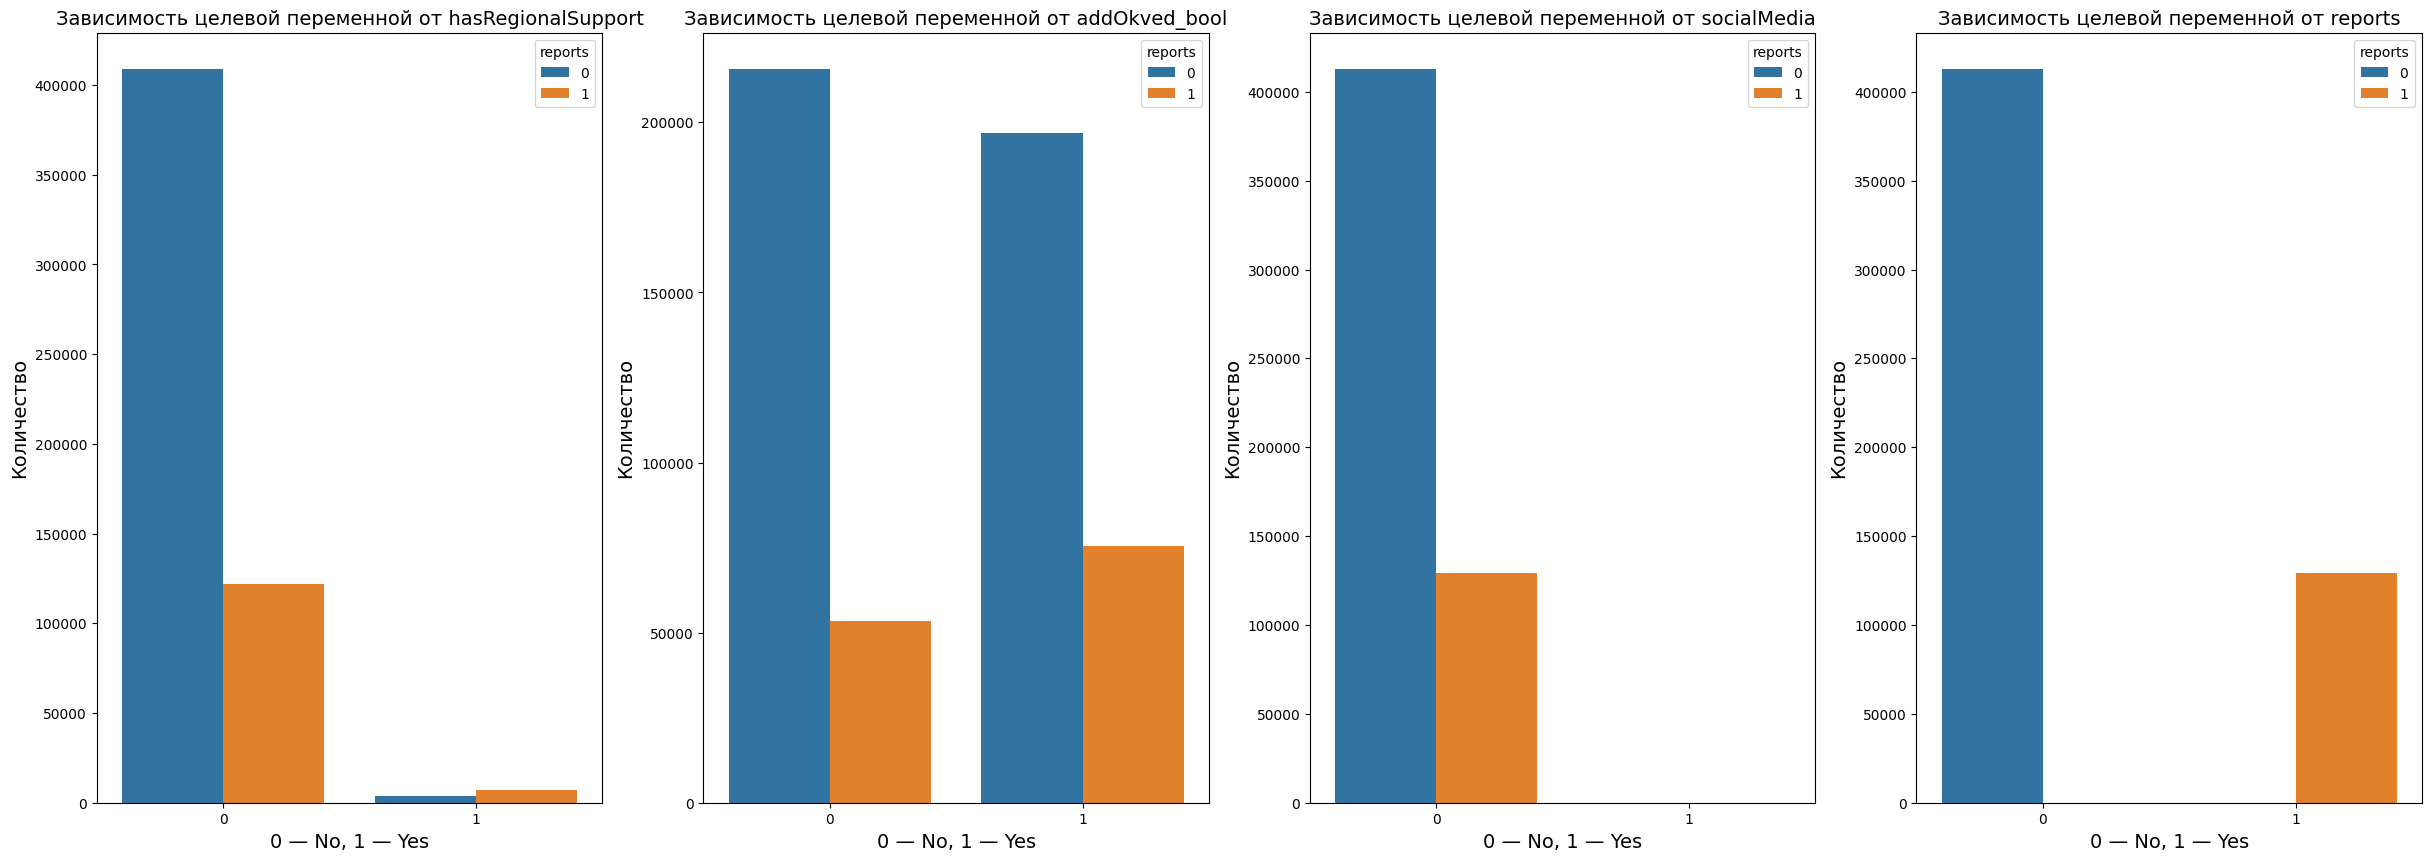

In [6]:
# Посмотрим влияние данных признаков на получение государственного финансирования

# выделяем имена признаков 
features = ['hasRegionalSupport', 'addOkved_bool', 'socialMedia', 'reports']
n = len(features) 
fig, axes = plt.subplots(1, n, figsize=(30, 10)) 

# создаем цикл для всех признаков из списка 
for i, feature in enumerate(features): 
    # строим графики
    countplot = sns.countplot(x=feature, hue='reports', data = df_clean, ax=axes[i])
    countplot.set_title('Зависимость целевой переменной от {}'.format(feature), fontsize=14)
    countplot.set_xlabel('0 — No, 1 — Yes', fontsize=14)
    countplot.set_ylabel('Количество', fontsize=14);

Среди НКО - получателей государственного финансирования, преобладают организации, не получавшие региональную поддержку в качестве СО НКО (возможно их просто больше по численности), имеющие дополнительный ОКВЭД и отчеты, поданные в Минюст РФ. По сведениям об учетных записях в соцсетях сложно сделать выводы, т.к. данных очень мало.
> Предварительно можно сделать вывод о том, что на получение государственного финансирования влияет наличие дополнительного ОКВЭД и сведений о региональной поддержке в качестве СО НКО.

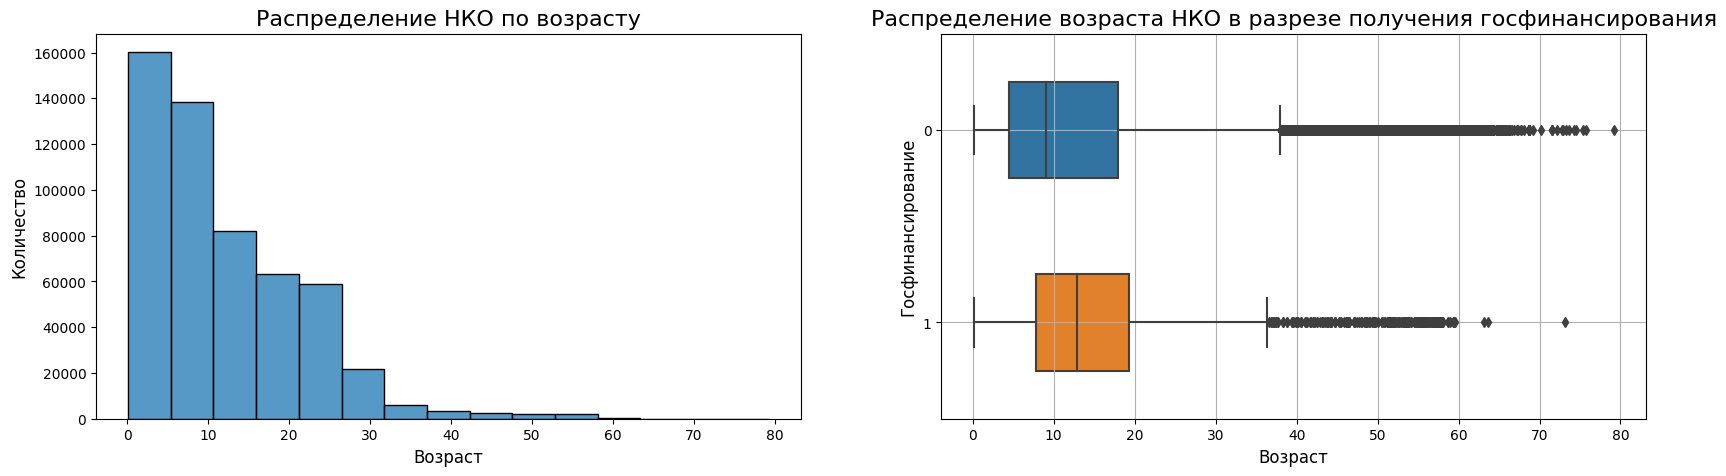

In [7]:
# Посмотрим на зависимость получения государственного финансирования от возраста организации

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(df_clean.age_org, bins=15, ax=axes[0])
axes[0].set_xlabel('Возраст',fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Распределение НКО по возрасту', fontsize=16);

boxplot = sns.boxplot(
    data=df_clean,
    x='age_org',
    y='target',
    #palette=my_pal,
    orient='h',
    width=0.5, 
    ax=axes[1]
)
boxplot.set_title('Распределение возраста НКО в разрезе получения госфинансирования', fontsize=16)
boxplot.set_xlabel('Возраст',fontsize=12)
boxplot.set_ylabel('Госфинансирование', fontsize=12)
boxplot.grid();

Большая часть НКО находится в возрастном диапазоне от 0 до 11 лет. 
Медианный возраст НКО, получивших государственное финансирование выше, чем не получивших (13 и 9 лет соответственно). Размах возраста и возрастной интервал у первых чуть меньше.
> Основываясь на данных можно сделать вывод, что возраст НКО влияет на получение государственого финансирования.

In [8]:
# распределение НКО по регионам, выделим первые 10
df_clean.regionName.value_counts().head(10)

Москва                     56421
Московская область         29748
Санкт-Петербург            21137
Краснодарский край         17638
Свердловская область       15858
Новосибирская область      13689
Ростовская область         12379
Республика Башкортостан    12268
Республика Татарстан       12186
Самарская область          11242
Name: regionName, dtype: int64

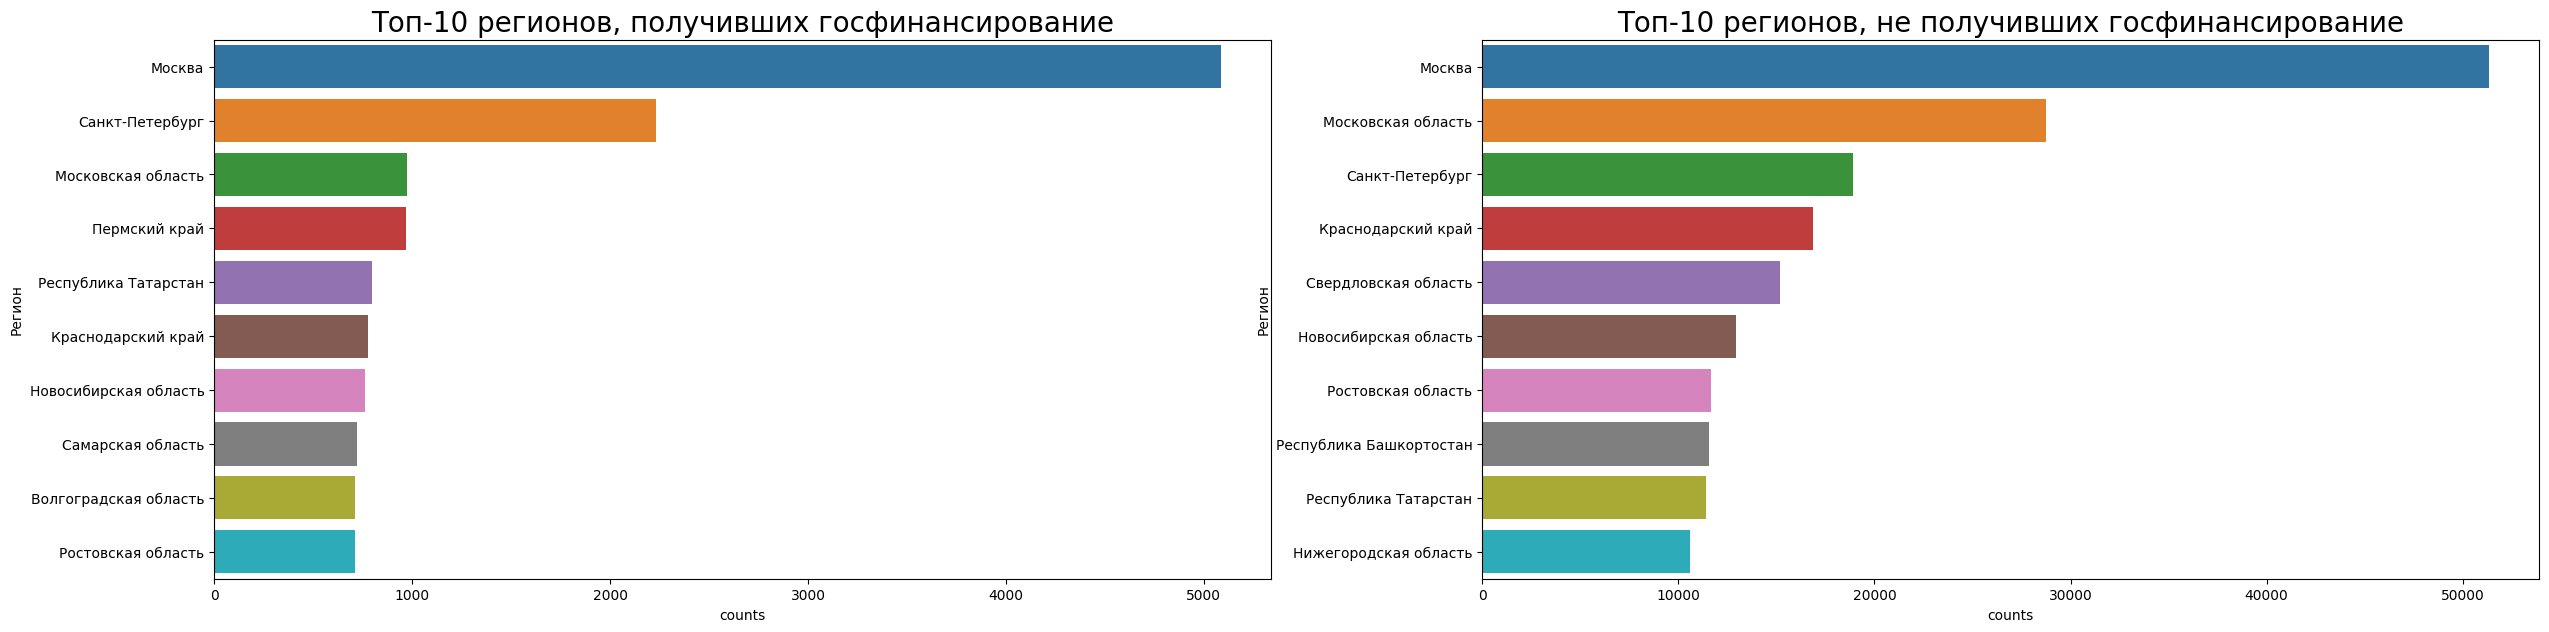

In [9]:
# разделим датасет на две группы по целевому признаку
df_target_1 = df_clean[df_clean.target == 1]
df_target_0 = df_clean[df_clean.target == 0]

# посмотрим влияние региона НКО на получение госфинансирования
df_region_gr1 = df_target_1['regionName'].value_counts().head(10).reset_index(name='counts').rename(columns={'index': 'Регион'})
df_region_gr0 = df_target_0['regionName'].value_counts().head(10).reset_index(name='counts').rename(columns={'index': 'Регион'})

fig, axes = plt.subplots(1, 2, figsize=(30, 7))
sns.barplot(df_region_gr1, x="counts", y="Регион", ax=axes[0])
axes[0].set_title('Топ-10 регионов, получивших госфинансирование', fontsize=20)

sns.barplot(df_region_gr0, x="counts", y="Регион", ax=axes[1])
axes[1].set_title('Топ-10 регионов, не получивших госфинансирование', fontsize=20);

Москва находится на первом месте среди регионов, как получивших, так и неполучивших госфинасирование, что является логичным, т.к. большинство НКО находится в данном регионе. Однако, начиная с 4 места данные разнятся. Например, Пермский край находится на 4 месте, среди регионов-получателей госфинансирования, однако он не вошел в десятку регионов по численности НКО. А Свердловская область находится на 5 месте по численности НКО, однако не вошла в десятку регионов-получателей госфинансирования.
> Исходя из анализа пока сложно сделать однозначный вывод о влиянии региона на получение государственного финансирования.

In [10]:
# распределение НКО по организационно-правовым формам (ОПФ)
df_clean.opf_group.value_counts()

Общественная организация                       106890
Товарищества                                    81387
Автономная организация                          48638
Потребительский кооператив                      48127
Гаражные и гаражно-строительные кооперативы     45417
Фонд                                            35763
Партнерства                                     32852
Религиозная организация                         32381
Другие учреждения                               22557
Профсоюз                                        20166
Частное учреждение                              20163
Другие кооперативы                              19635
Ассоциации_союзы                                17460
Общества                                        10131
Name: opf_group, dtype: int64

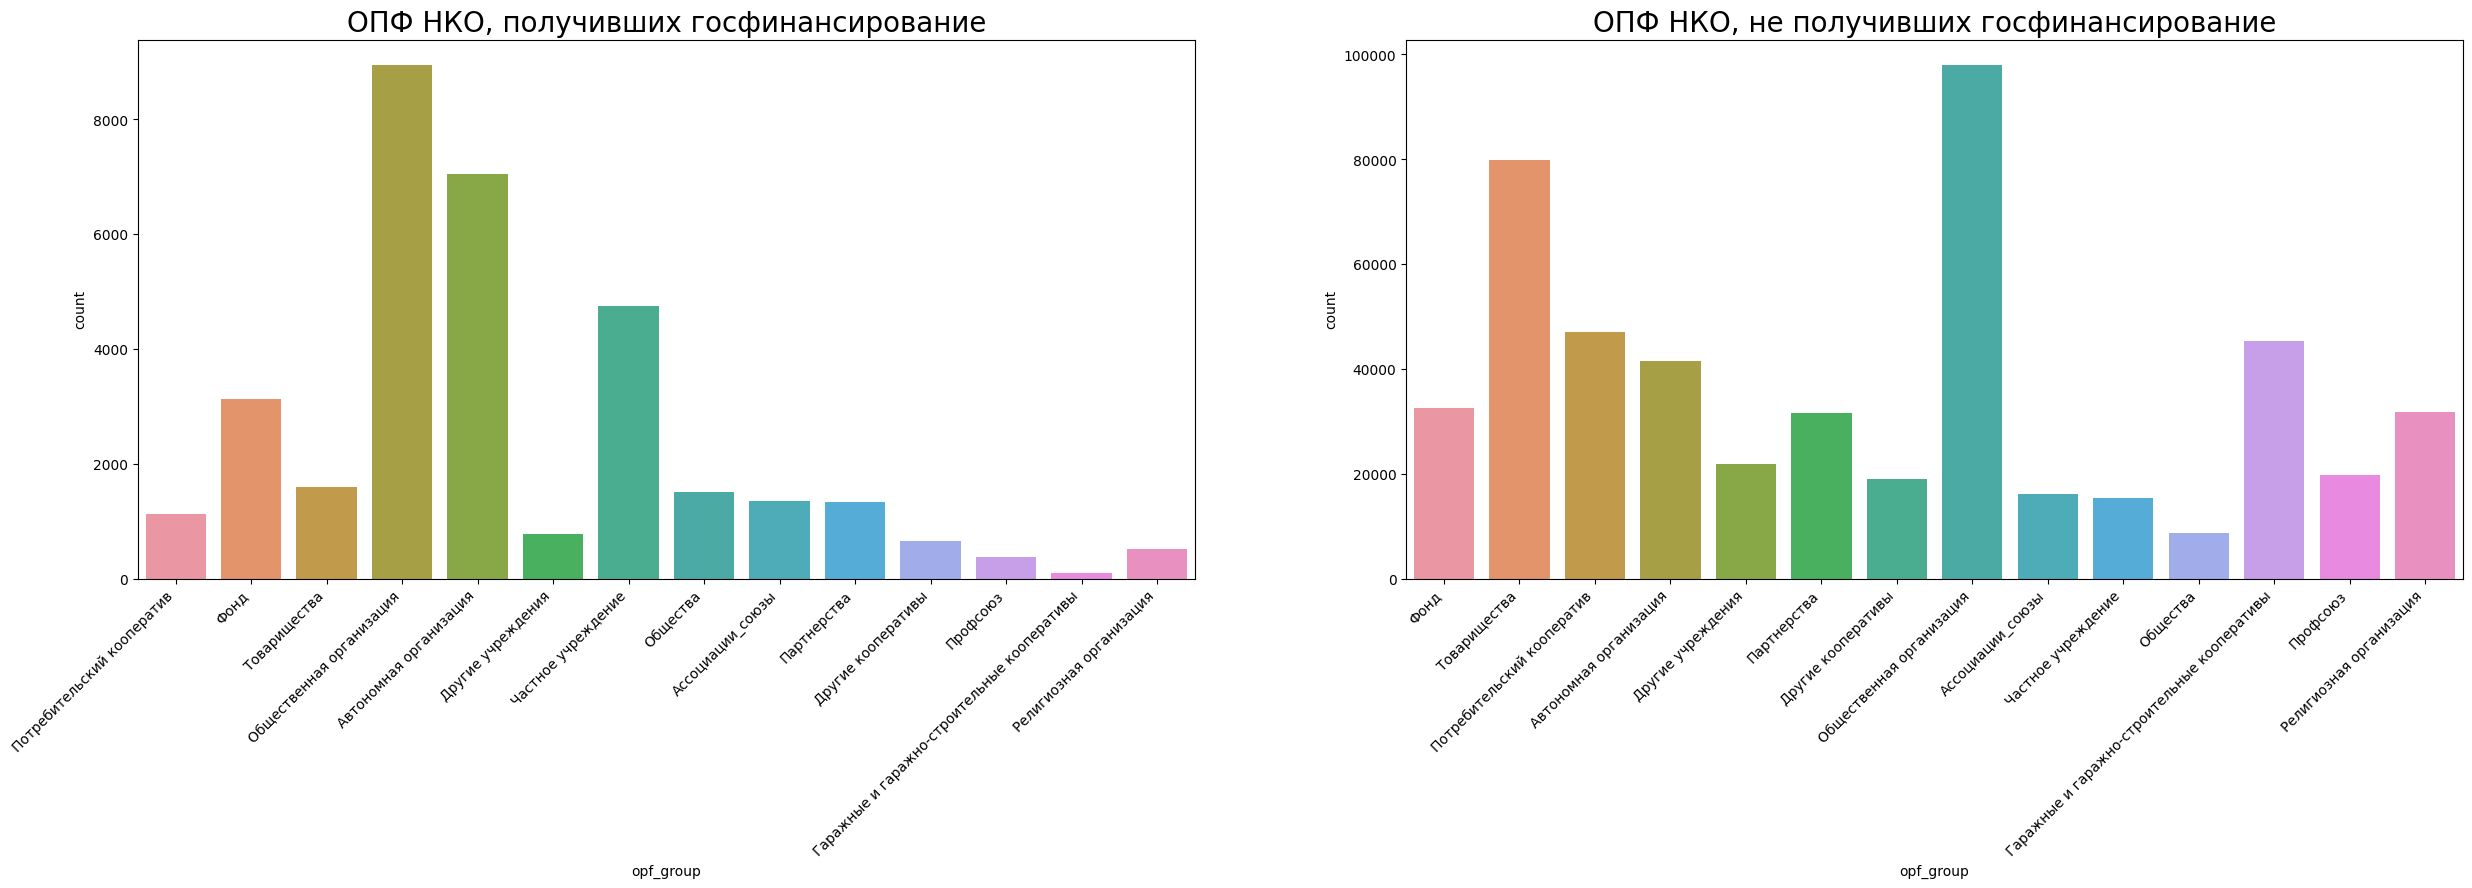

In [11]:
# посмотрим влияние ОПФ НКО на получение госфинансирования

fig, axes = plt.subplots(1, 2, figsize=(30, 7))
countplot = sns.countplot(df_target_1, x="opf_group",  ax=axes[0])
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')
axes[0].set_title('ОПФ НКО, получивших госфинансирование', fontsize=20);

countplot = sns.countplot(df_target_0, x="opf_group",  ax=axes[1])
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')
axes[1].set_title('ОПФ НКО, не получивших госфинансирование', fontsize=20);

Т.к. "Общественные организации" преобладают среди всех НКО, то соответственно их больше всего как среди получателей, так и неполучателей госфинансирования.
Среди получивших доход от государства также выделяются автономные организации, частные учреждения и фонды. 
Среди не получивших доход - товарищества, гаражные, гаражно-строительные и потребительские кооперативы.
> Основываясь на графиках, можно предположить, что организационно-правовая форма влияет на получение государственного финансирования.

In [12]:
# распределение НКО по видам экономической деятельности (ВЭД), выделим первые 10
df_clean.mainOkved_name.value_counts().head(10)

Деятельность прочих общественных организаций, не включенных в другие группировки                                                    100573
Деятельность стоянок для транспортных средств                                                                                        38243
Деятельность религиозных организаций                                                                                                 32500
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе                                                     29638
Деятельность профессиональных союзов                                                                                                 25200
Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе                                                   22985
Управление недвижимым имуществом за вознаграждение или на договорной основе                                                          20855
Управление эксплуатацией жи

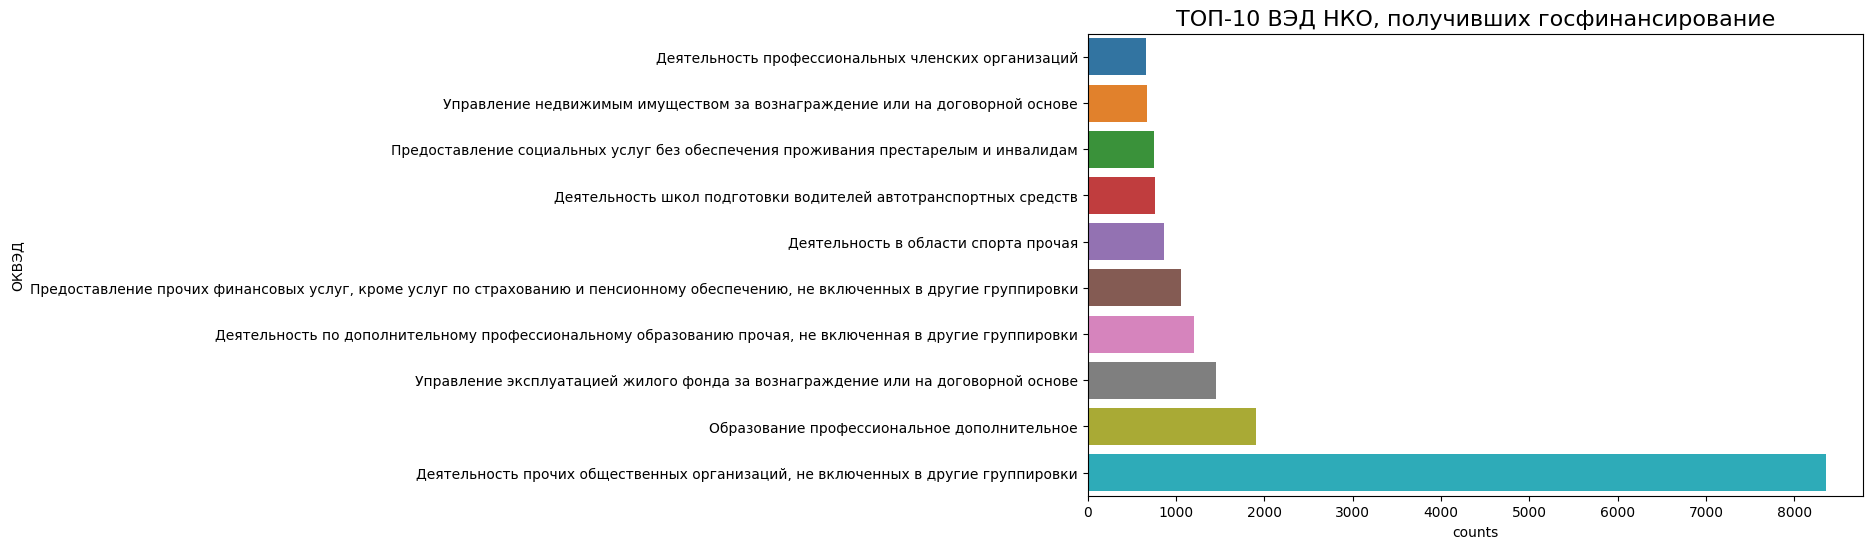

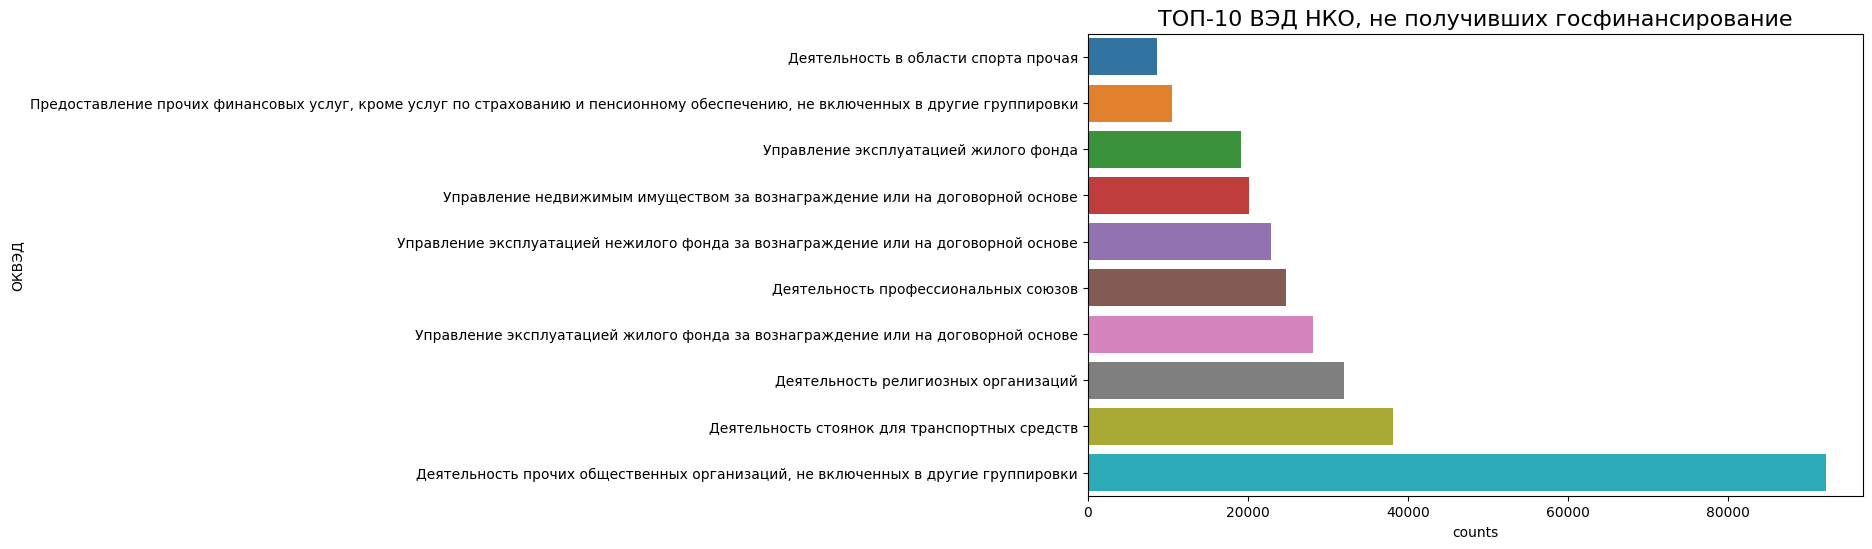

In [13]:
# посмотрим влияние ВЭД НКО на получение госфинансирования

df_okved_gr0 = df_target_0['mainOkved_name'].value_counts().head(10).reset_index(name='counts').rename(columns={'index': 'ОКВЭД'}).sort_values(by='counts')
df_okved_gr1 = df_target_1['mainOkved_name'].value_counts().head(10).reset_index(name='counts').rename(columns={'index': 'ОКВЭД'}).sort_values(by='counts')

fig = plt.figure(figsize=(10, 6))
sns.barplot(df_okved_gr1, x="counts", y="ОКВЭД")
plt.title('ТОП-10 ВЭД НКО, получивших госфинансирование', fontsize=16);

fig = plt.figure(figsize=(10, 6))
sns.barplot(df_okved_gr0, x="counts", y="ОКВЭД")
plt.title('ТОП-10 ВЭД НКО, не получивших госфинансирование', fontsize=16);

"Деятельность прочих общественных организаций, не включенных в другие группировки" преобладает в общем количестве ВЭД НКО, поэтому данный вид деятельности выделяется в обеих группах.
Также в тройку получателей госфинансирования входят: "Образование профессиональное дополнительное" и "Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе".
Среди неполучателей выделяются: "Деятельность стоянок для транспортных средств" и "Деятельность религиозных организаций". 
> Т.к. некоторые виды экономической деятельности находятся в обеих группах, сложно сделать однозначный вывод о влиянии данного признака на получение государственного финансирования.

## Статистический анализ данных

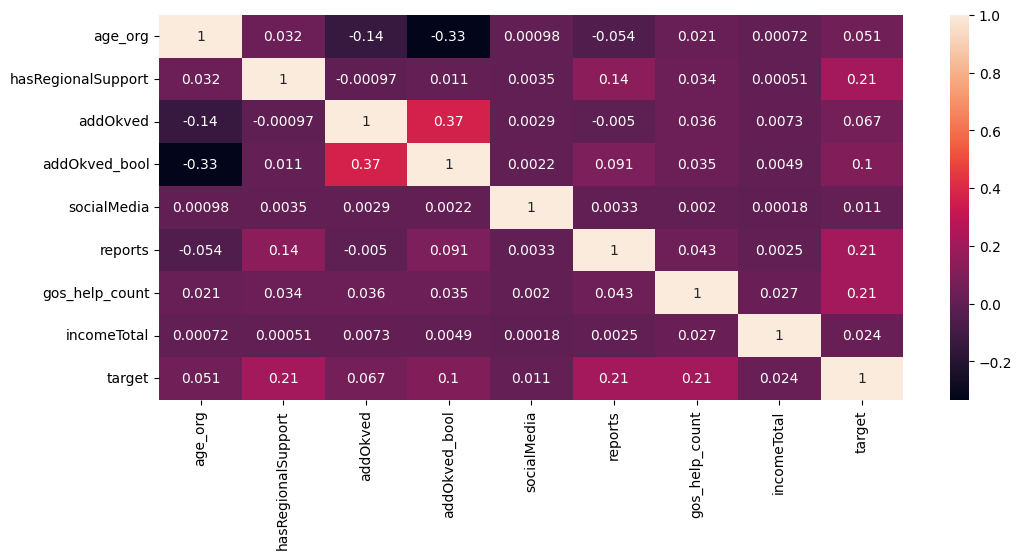

In [14]:
# карта корреляций между числовыми признаками
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df_clean.corr(), annot=True);

Cильной корреляции между числовыми признаками не наблюдается.

Признаки addOkved и addOkved_bool дублируют друг друга, поэтому удалим признак менее всего коррелирующий с целевой переменной - addOkved.
Также удалим признаки 'socialMedia' (т.к. заполненной информации очень мало - менее 1%) и 'reports' (т.к. информация некорректная, поскольку все НКО обязаны сдавать отчеты).

In [15]:
df_clean = df_clean.drop(['addOkved', 'socialMedia', 'reports'], axis=1)

In [16]:
#sns.pairplot(df_clean)
# зависимость между числовыми признаками отсутствует

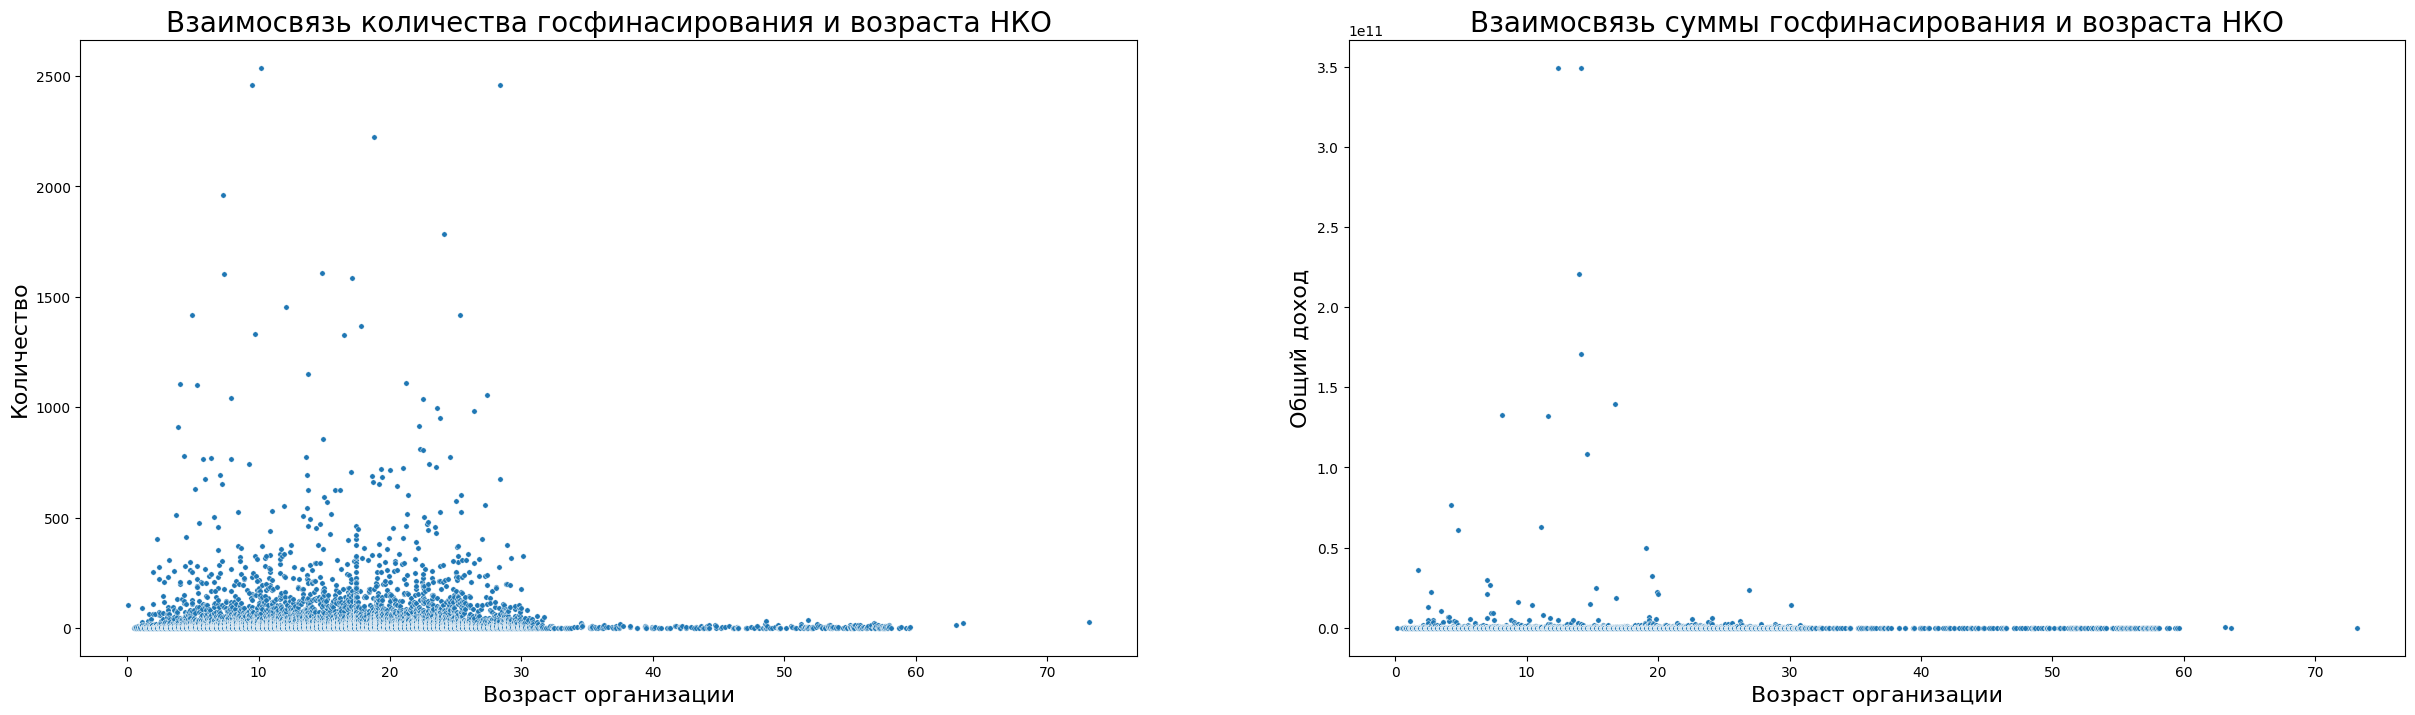

In [17]:
# Посмотрим зависит ли количество и сумма государственного финансирования от возраста НКО

fig, axes = plt.subplots(1, 2, figsize=(30, 8))

scatterplot1 = sns.scatterplot(
    data=df_target_1,
    x='age_org',
    y='gos_help_count',
    s=15,
    ax=axes[0]
    )
scatterplot1.set_title('Взаимосвязь количества госфинасирования и возраста НКО', fontsize=20)
scatterplot1.set_xlabel('Возраст организации', fontsize=16)
scatterplot1.set_ylabel('Количество', fontsize=16);

scatterplot2 = sns.scatterplot(
    data=df_target_1,
    x='age_org',
    y='incomeTotal',
    s=15, 
    ax=axes[1]
    )
scatterplot2.set_title('Взаимосвязь суммы госфинасирования и возраста НКО', fontsize=20)
scatterplot2.set_xlabel('Возраст организации', fontsize=16)
scatterplot2.set_ylabel('Общий доход', fontsize=16);

Больше всего НКО, получивших госфинасирование, находятся в диапазоне от 0 до 30 лет, что соответствует размаху возраста, показанной на диаграмме - boxplot.
Однако явная взаимосязь между суммой, количеством госфинансирования и возрастом на первый взгляд отсутствует. 

Проверим данное предположение с помощью статистических тестов.

Сформулируем гипотезу:

Н0 - возраст НКО не влияет на доход

Н1 - возраст НКО влияет на доход

Уровень значимости α = 0.05

Целевой показатель - incomeTotal (общая сумма дохода)

Возрастная группа - категориальный признак

In [18]:
# Разделим выборку на 3 равные группы по возрасту

df_stat1 = np.array(df_target_1[df_target_1['age_org'] < 10]['incomeTotal'])
df_stat2 = np.array(df_target_1[(df_target_1['age_org'] >= 10) & (df_target_1['age_org'] < 18)]['incomeTotal'])     
df_stat3 = np.array(df_target_1[df_target_1['age_org'] >= 18]['incomeTotal'])    

# размер выборок
df_stat1.shape[0], df_stat2.shape[0], df_stat3.shape[0]

(11985, 11046, 10177)

In [19]:
# Проверка данных на нормальность по критерию Шапиро-Уилка

# сформулируем гипотезу для проверки данных на нормальность
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# установим уровень значимости
alpha = 0.05

# проверим в каждой группе
stat, p = shapiro(df_stat1)
#stat, p = shapiro(df_stat2)
#stat, p = shapiro(df_stat3)

# интерпретация
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [20]:
# Т.к. выборка большая, проверим дополнительно данные на нормальность с помощью теста Д’Агостино

stat, p = normaltest(df_stat1)

# Интерпретация
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [21]:
# Т.к. данные не распределены нормально, для сравнения более двух независимых групп выбираем непараметрический критерий Краскела - Уоллиса
corr, p = stats.mstats.kruskalwallis(df_stat1, df_stat2, df_stat3)

if p > alpha:
    print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу об отсутствии зависимости между переменными.")
else:
    print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу об отсутствии зависимости между переменными.")

2.526076992430808e-10 <= 0.05. Мы отвергаем нулевую гипотезу об отсутствии зависимости между переменными.


In [22]:
# Проверим дополнительно влияние возраста НКО на количество госфинансирования

df_stat1 = np.array(df_target_1[df_target_1['age_org'] < 10]['gos_help_count'])
df_stat2 = np.array(df_target_1[(df_target_1['age_org'] >= 10) & (df_target_1['age_org'] < 18)]['gos_help_count'])     
df_stat3 = np.array(df_target_1[df_target_1['age_org'] >= 18]['gos_help_count'])    

corr, p = stats.mstats.kruskalwallis(df_stat1, df_stat2, df_stat3)

if p > alpha:
    print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу об отсутствии зависимости между переменными.")
else:
    print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу об отсутствии зависимости между переменными.")

0.0 <= 0.05. Мы отвергаем нулевую гипотезу об отсутствии зависимости между переменными.


> Таким образом, статистические тесты показали, что возраст НКО влияет на количество и сумму государственного финансирования.

## Проектирование и отбор признаков. Нормализация.

In [23]:
# к признакам 'ОКВЭД' и 'регион' применим двоичное кодирование, т.к. у них много уникальных значений

cols_to_bin = ['mainOkved_name', 'regionName']
bin_encoder = ce.BinaryEncoder(cols=cols_to_bin) 
type_bin = bin_encoder.fit_transform(df_clean[cols_to_bin])
df_model = pd.concat([df_clean, type_bin], axis=1)
df_model.drop(cols_to_bin,axis=1, inplace=True)

# к признаку 'opf_group' - однократное кодирование

encoder = ce.OneHotEncoder(cols='opf_group') # указываем столбец для кодирования
type_hot = encoder.fit_transform(df_model['opf_group'])
df_model = pd.concat([df_model, type_hot], axis=1)
df_model.drop('opf_group', axis=1, inplace=True)
df_model.describe()

,age_org,hasRegionalSupport,addOkved_bool,gos_help_count,incomeTotal,target,mainOkved_name_0,mainOkved_name_1,mainOkved_name_2,mainOkved_name_3,...,opf_group_5,opf_group_6,opf_group_7,opf_group_8,opf_group_9,opf_group_10,opf_group_11,opf_group_12,opf_group_13,opf_group_14
count,541567.000000,541567.000000,541567.000000,541567.000000,5.415670e+05,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,...,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000,541567.000000
mean,12.062499,0.020221,0.503044,0.768136,5.446457e+06,0.061318,0.011956,0.047473,0.094411,0.198310,...,0.041651,0.060661,0.036256,0.197372,0.032240,0.037231,0.018707,0.083862,0.037236,0.059791
std,9.568003,0.140755,0.499991,14.636437,8.745437e+08,0.239914,0.108688,0.212649,0.292400,0.398727,...,0.199791,0.238708,0.186926,0.398016,0.176636,0.189327,0.135488,0.277181,0.189341,0.237100
min,0.100000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.300000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.100000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,79.200000,1.000000,1.000000,2538.000000,3.494067e+11,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541567 entries, 0 to 541566
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age_org             541567 non-null  float64
 1   hasRegionalSupport  541567 non-null  int64  
 2   addOkved_bool       541567 non-null  int64  
 3   gos_help_count      541567 non-null  int64  
 4   incomeTotal         541567 non-null  float64
 5   target              541567 non-null  int64  
 6   mainOkved_name_0    541567 non-null  int64  
 7   mainOkved_name_1    541567 non-null  int64  
 8   mainOkved_name_2    541567 non-null  int64  
 9   mainOkved_name_3    541567 non-null  int64  
 10  mainOkved_name_4    541567 non-null  int64  
 11  mainOkved_name_5    541567 non-null  int64  
 12  mainOkved_name_6    541567 non-null  int64  
 13  mainOkved_name_7    541567 non-null  int64  
 14  mainOkved_name_8    541567 non-null  int64  
 15  mainOkved_name_9    541567 non-nul

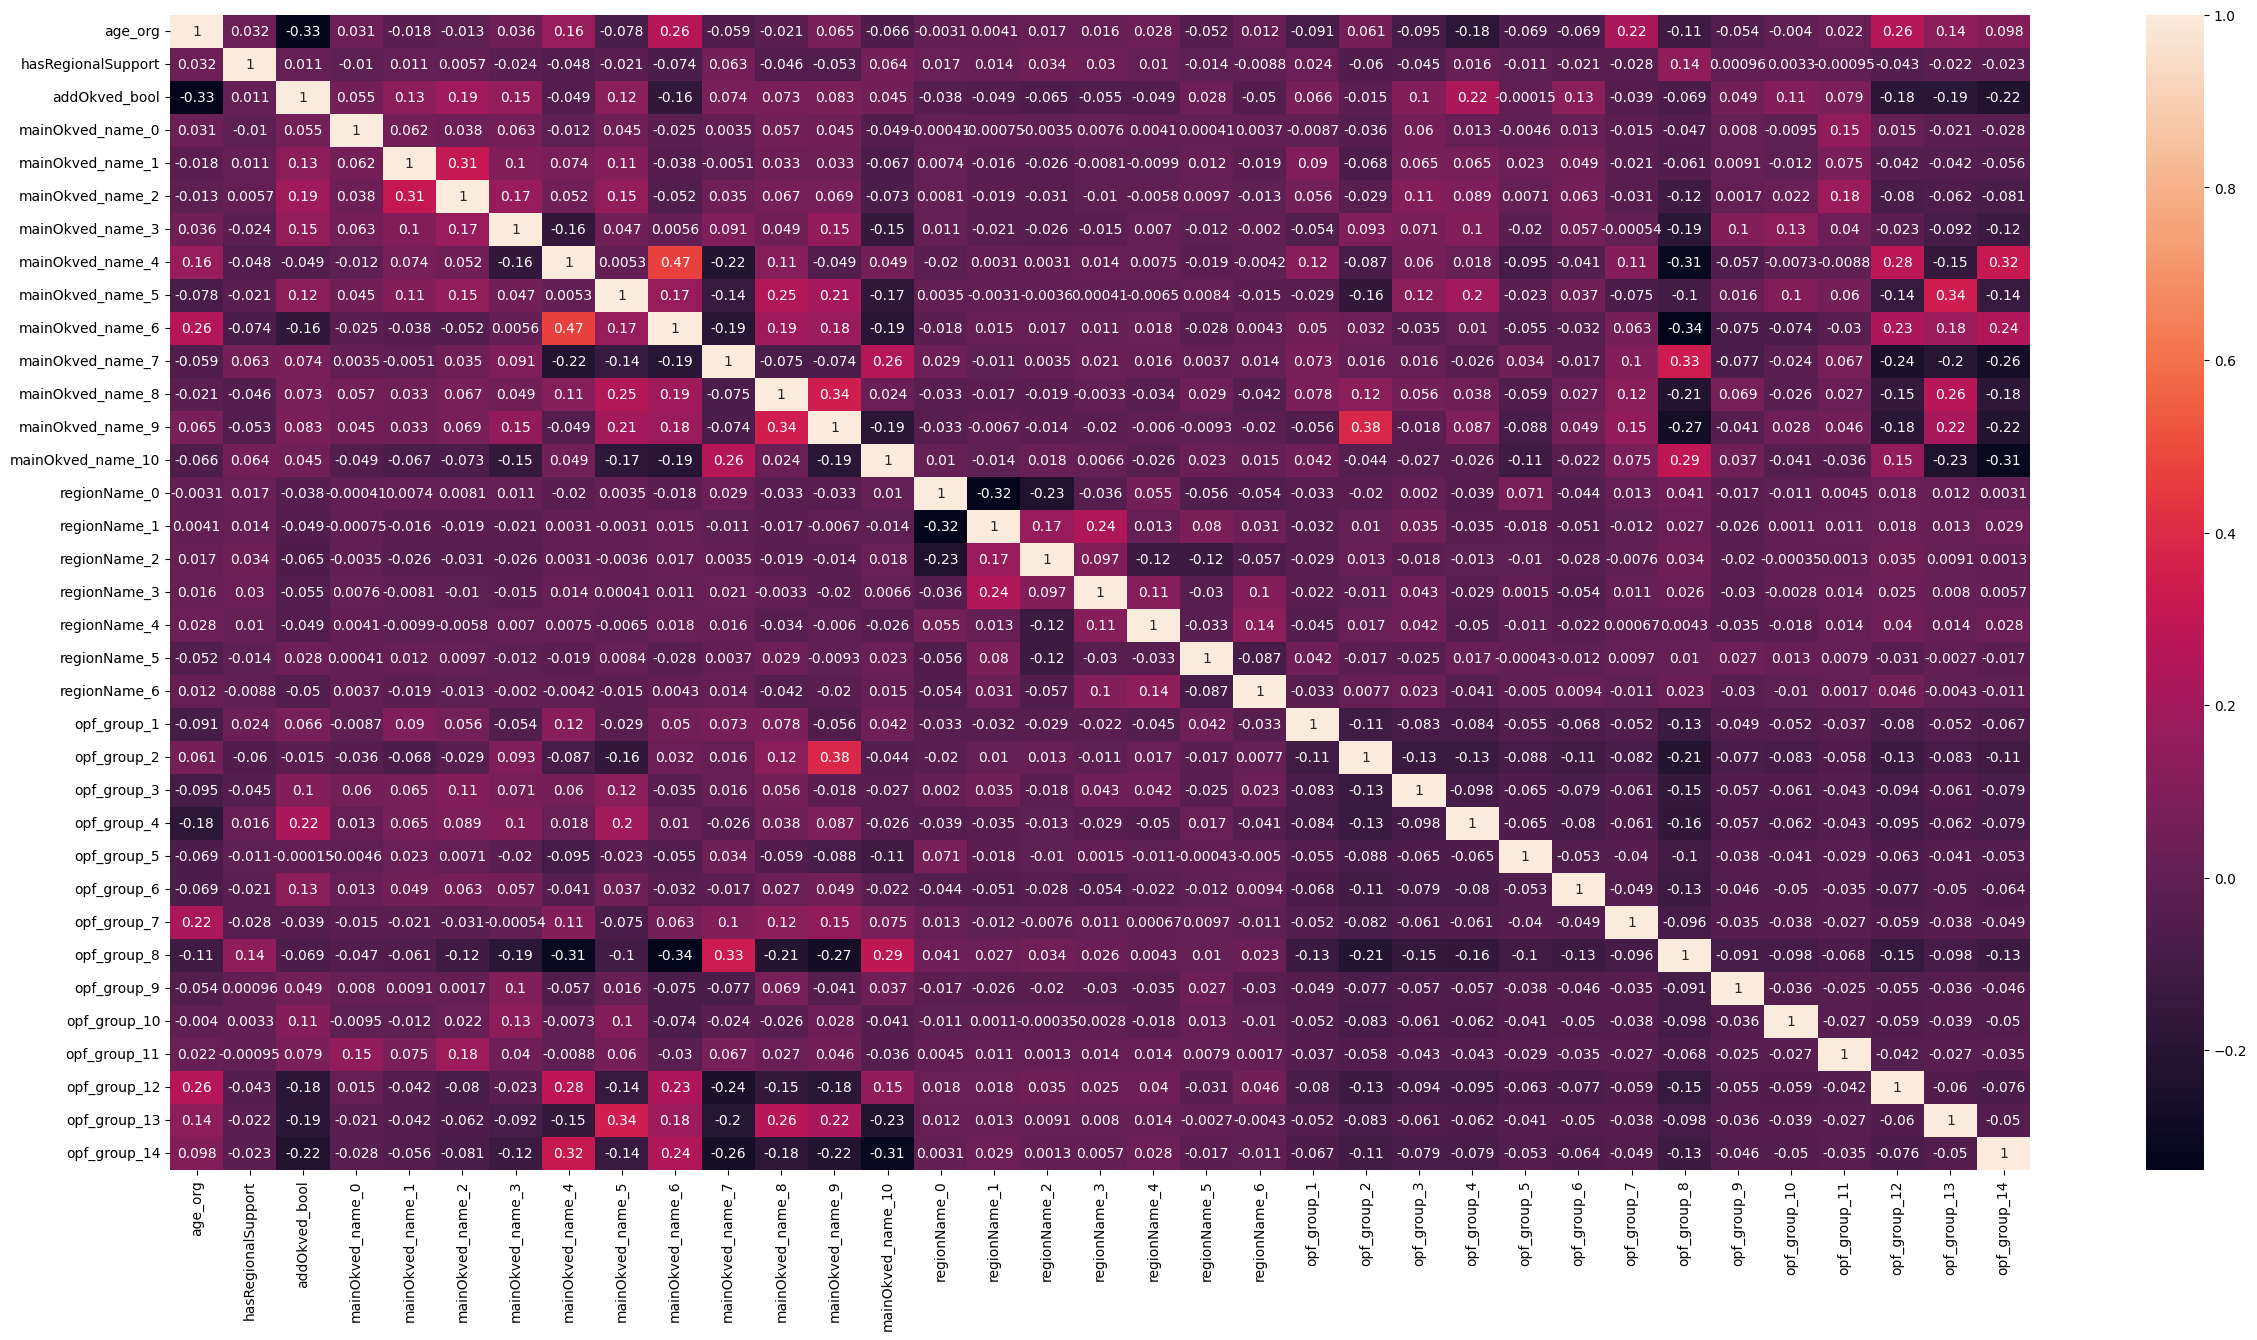

In [25]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 15))
# уберем целевой признак и связанные с ним
cols_target = ['target', 'incomeTotal', 'gos_help_count']
sns.heatmap(df_model.drop(cols_target, axis= 1).corr(), annot = True);

Мультиколлинеарность между признаками отсутствует.

In [26]:
# для дополнительной визуализации построим столбчатую диаграмму для ранжированных коэффициентов корреляции
corrs = round(df_model.corr(), 2).drop(cols_target, axis=0)

fig = px.bar(corrs['target'].sort_values(ascending=False),
             x=list(corrs['target'].sort_values(ascending=False).index),
             y='target',
             text_auto=True,
             title='Ранжирование коэффициентов корреляции'
             )

fig.show();

![](//plotly/newplot1)

С целевой переменной больше всего коррелирует признак 'hasRegionalSupport'.

0    0.938682
1    0.061318
Name: target, dtype: float64

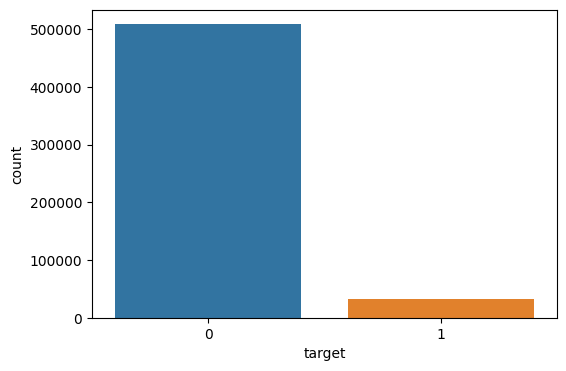

In [27]:
# смотрим на сбалансированность целевого признака:
display(df_model['target'].value_counts(normalize=True))
fig, ax = plt.subplots(figsize = (6, 4)) 
sns.countplot(data=df_model, x='target');

Т.к. классы очень не сбалансированны, создадим новый dataframe методом пересэмплирования (oversampling) - продублируем объекты малого класса. 

Примечание: пробовала использовать алгоритм SMOTE, происходит переобучение: метрика F1 на тестовой выборке показывает очень низкое значение.

In [28]:
# посмотрим на отношение количества строк 0 к 1 target
rat = len(df_model.loc[df_model['target']==0])//len(df_model.loc[df_model['target']==1])
rat

15

0    0.505087
1    0.494913
Name: target, dtype: float64

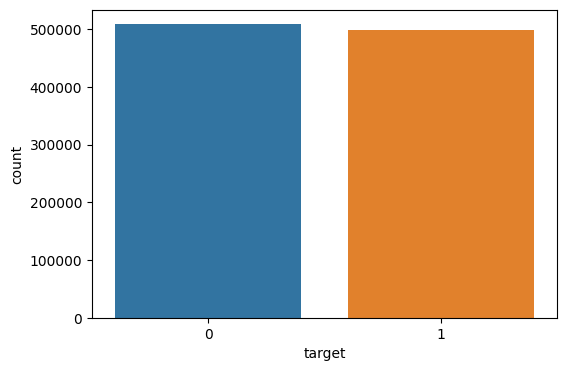

In [29]:
# продублируем rat раз
df_1 = df_model.loc[df_model['target']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]        
df_model_new = pd.concat([df_model.loc[df_model['target']==0], df_1]).sample(frac=1)

# смотрим на сбалансированность целевого признака:
display(df_model_new['target'].value_counts(normalize=True))
fig, ax = plt.subplots(figsize = (6, 4)) 
sns.countplot(data=df_model_new, x='target');

In [30]:
# размер df
df_model_new.shape

(1006479, 38)

In [31]:
# Разделяем выборку на тренировочную и тестовую в соотношении 70/30. 
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).
X = df_model_new.drop(cols_target, axis=1)
y = df_model_new['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.3)
# проверим соотношения классов
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Test:\n', y_test.value_counts(normalize=True), sep='')

Train:
0    0.505086
1    0.494914
Name: target, dtype: float64
Test:
0    0.505087
1    0.494913
Name: target, dtype: float64


Примечание: При отборе признаков с помощью метода SelectKBest наблюдается снижение метрик качества, поэтому оставила все признаки.

In [32]:
# размер выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape  

((704535, 35), (301944, 35), (704535,), (301944,))

In [33]:
# Нормального распределения среди признаков не наблюдается, поэтому проведём нормализацию распределений признаков, используя класс MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Построение и обучение модели

Построим несколько baseline-моделей (с параметрами по умолчанию) с помощью различных алгоритмов.

В качестве метрик выберем:

Accuracy — доля правильных ответов модели среди всех ответов,

F1 - взвешенное среднее гармоническое между precision и recall.

## *Логистическая регрессия*

In [34]:
# зафиксируем значения
random_state = 42
# создаем объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=random_state)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Выводим значения метрики
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Accuracy_Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy_Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

F1_Train: 0.74
F1_Test: 0.74
Accuracy_Train: 0.74
Accuracy_Test: 0.74


## *Деревья решений*

In [35]:
# cоздаем объект класса DecisionTree 
model_tree = tree.DecisionTreeClassifier(random_state=random_state)
# Обучаем модель по алгоритму CART
model_tree.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = model_tree.predict(X_train_scaled)
y_test_pred = model_tree.predict(X_test_scaled)

# Выводим значения метрики
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Accuracy_Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy_Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

F1_Train: 0.97
F1_Test: 0.95
Accuracy_Train: 0.97
Accuracy_Test: 0.94


## *Случайный лес*

In [36]:
# cоздаем объект класса RandomForest
forest = ensemble.RandomForestClassifier(random_state=random_state)
# Обучаем модель
forest.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = forest.predict(X_train_scaled)
y_test_pred = forest.predict(X_test_scaled)

# Выводим значения метрики
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Accuracy_Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy_Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

F1_Train: 0.97
F1_Test: 0.95
Accuracy_Train: 0.97
Accuracy_Test: 0.95


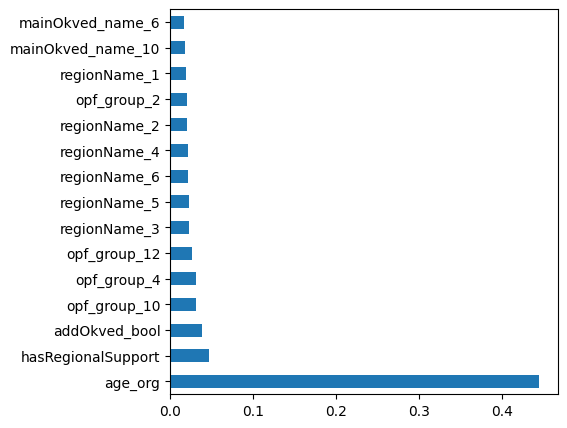

In [37]:
# посмотрим на самые важные признаки для модели
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

## *Градиентный бустинг*

In [38]:
# cоздаем объект класса GradientBoosting 
gr_boost = ensemble.GradientBoostingClassifier(random_state=random_state)
# Обучаем модель
gr_boost.fit(X_train_scaled, y_train)

# Делаем предсказание
y_train_pred = gr_boost.predict(X_train_scaled)
y_test_pred = gr_boost.predict(X_test_scaled)

# Выводим значения метрики
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Accuracy_Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy_Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

F1_Train: 0.77
F1_Test: 0.77
Accuracy_Train: 0.76
Accuracy_Test: 0.77


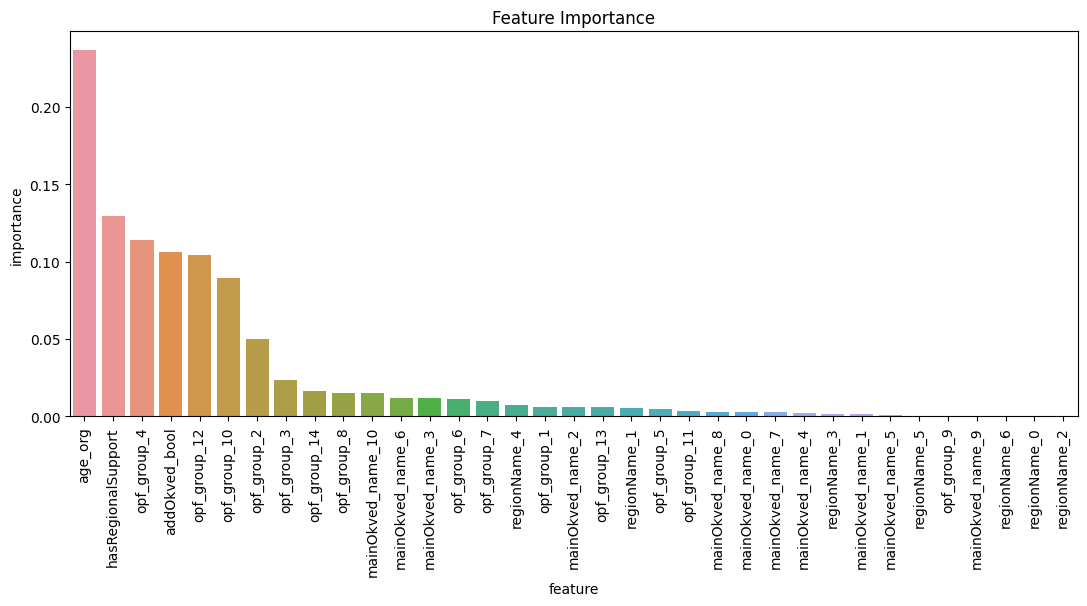

In [39]:
# посмотрим на самые важные признаки для модели
features = pd.DataFrame(X_train_scaled, columns = X.columns).columns           
importances = gr_boost.feature_importances_

df_imp = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

# строим столбчатую диаграмму
fig, ax = plt.subplots(figsize = (13, 5)) 
sns.barplot(df_imp, x = 'feature', y = 'importance', ax = ax)
ax.set_title('Feature Importance')               
ax.xaxis.set_tick_params(rotation = 90);

Самые высокие значения целевых метрик показали модели RandomForest и DecisionTree. Скорей всего наблюдается переобучение, т.к. максимальная глубина дерева не указана.

Среди важных признаков для модели со значительным отрывом выделяется возраст организации, на втором месте - наличие сведений о региональной поддержке в качестве СО НКО.

Попробуем подобрать оптимальный интервал глубины дерева с помощью метода перекрестной проверки. 

In [40]:
# cоздание деревьев решений с разной глубиной
max_depths = [20, 30, 40, 50]
for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    f1_score = metrics.f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Глубина дерева: {max_depth}, f1_score: {f1_score}')
    print(f'Глубина дерева: {max_depth}, accuracy: {accuracy}')

Глубина дерева: 20, f1_score: 0.8602418435446476
Глубина дерева: 20, accuracy: 0.8554632647113372
Глубина дерева: 30, f1_score: 0.9376795862333185
Глубина дерева: 30, accuracy: 0.9353522507484832
Глубина дерева: 40, f1_score: 0.9461775423810226
Глубина дерева: 40, accuracy: 0.9443340486977718
Глубина дерева: 50, f1_score: 0.9467089057660215
Глубина дерева: 50, accuracy: 0.9449003788782026


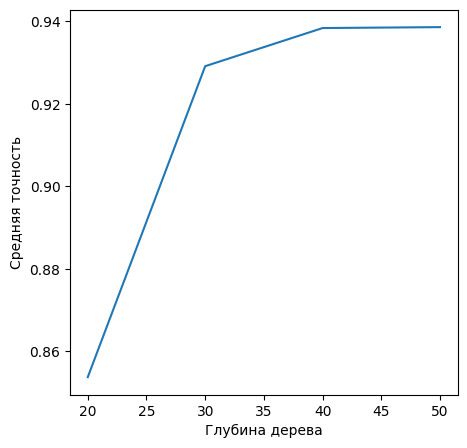

In [41]:
# посмотрим на графике
 
mean_scores = []
for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())
 
# Вывод графика средней точности на различных значениях глубины
fig, ax = plt.subplots(figsize = (5, 5)) 
plt.plot(max_depths, mean_scores)
plt.xlabel('Глубина дерева')
plt.ylabel('Средняя точность')
plt.show();

Как видно на графике, с увеличением глубины дерева точность модели улучшается. После 40 уже стабилизируется.

Подберем гиперпараметры для модели RandomForest (т.к. она показала чуть лучший результат) с помощью метода оптимизации Optuna.

In [42]:
# Настроим оптимизацию гиперпараметров c помощью Optuna
def optuna_forest(trial):
  # задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
  n_estimators = trial.suggest_int('n_estimators', 120, 180, 20)
  max_depth = trial.suggest_int('max_depth', 30, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 5, 2)

  # Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          criterion=criterion,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state
                                          )
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  # применим cross validation
  score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_forest, n_trials = 30)

# строим и обучаем модель
model_opt_forest = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model_opt_forest.fit(X_train_scaled, y_train)

# выведем наилучшие значения гиперпараметров и метрики
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# выведим значения метрики
print("f1_score на обучающей выборке: {:.2f}".format(study.best_value))

[I 2023-11-03 12:02:29,107] A new study created in memory with name: RandomForestClassifier
[I 2023-11-03 12:06:39,023] Trial 0 finished with value: 0.877409470058345 and parameters: {'criterion': 'entropy', 'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.877409470058345.
[I 2023-11-03 12:12:08,843] Trial 1 finished with value: 0.9113508349734689 and parameters: {'criterion': 'entropy', 'n_estimators': 180, 'max_depth': 35, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9113508349734689.
[I 2023-11-03 12:17:06,074] Trial 2 finished with value: 0.9068930582618169 and parameters: {'criterion': 'gini', 'n_estimators': 160, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9113508349734689.
[I 2023-11-03 12:21:54,562] Trial 3 finished with value: 0.8772732163970269 and parameters: {'criterion': 'entropy', 'n_estimators': 160, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9113508349734689.
[I 20

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 3}
f1_score на обучающей выборке: 0.91
f1_score на тестовой выборке: 0.92
Accuracy_Test: 0.92


In [49]:
# Делаем предсказание для модели на найденных гиперпараметрах
y_train_pred = model_opt_forest.predict(X_train_scaled)
y_test_pred = model_opt_forest.predict(X_test_scaled)

# Выводим значения метрик
print('F1_Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1_Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Accuracy_Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy_Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

F1_Train: 0.93
F1_Test: 0.92
Accuracy_Train: 0.93
Accuracy_Test: 0.92


In [43]:
# с помощью графика истории оптимизации  можно проверить, идет ли оптимизация гиперпараметров в правильном направлении 
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

![](//plotly/newplot2)

Как видно на графике, метрика максимизируется.

In [44]:
# график важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в максимизацию метрики
optuna.visualization.plot_param_importances(study, target_name="f1_score")

![](//plotly/newplot3)

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_samples_leaf (возможно задать больший интервал).

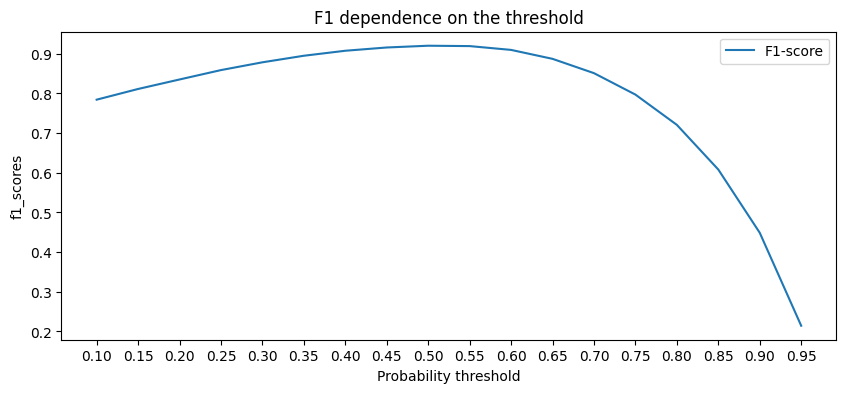

In [45]:
# Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке

# Делаем предсказание 
y_test_proba_pred = pd.Series(model_opt_forest.predict_proba(X_test_scaled)[:, 1]) 
# Инициализируем список, куда будем сохранять метрики.
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_forest = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    f1_score = metrics.f1_score(y_test, y_test_pred_forest)
    # Добавляем результат в список
    f1_scores.append(f1_score)
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('f1_scores')
ax.set_xticks(thresholds)
ax.legend();   

Наибольшее значение целевой метрики на тестовой выборке соотвествует thresholds=0,5-0.55. 

Не сильно отличается от значения по умолчанию, поэтому сравним метрики в тысячных долях.

In [46]:
# зададим порог вероятности по умолчанию
threshold_opt = 0.5

# Делаем предсказание из тестовой выборки
y_test_proba_pred = pd.Series(model_opt_forest.predict_proba(X_test_scaled)[:, 1])
y_test_pred_class = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрики
print('F1 score test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred_class)))
print('Accuracy_Test: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred_class)))

# зададим оптимальный порог вероятности
threshold_opt = 0.55

# Делаем предсказание из тестовой выборки
y_test_proba_pred = pd.Series(model_opt_forest.predict_proba(X_test_scaled)[:, 1])
y_test_pred_class = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрики
print('F1 score test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred_class)))
print('Accuracy_Test: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred_class)))

F1 score test: 0.920
Accuracy_Test: 0.917
F1 score test: 0.919
Accuracy_Test: 0.917


Разница в метриках не значительная, по умолчанию даже чуть лучше.

Построим предсказание вероятности получения НКО государственного финансирования на новых данных, с помощью модели случайного леса с подобранными гиперпараметрами.

In [52]:
# создание нового НКО
df_pred = pd.DataFrame({
    'regionName': ['Тюменская область'],
    'age_org': [8],
    'hasRegionalSupport': [0],
    'mainOkved_name': ['Образование профессиональное дополнительное'],
    'addOkved_bool': [1],
    'opf_name': ['Частное учреждение'],
})

# создание дополнительных признаков
df_pred['opf_name'] = df_pred['opf_name'].str.lower() 

def opf_group(name):
    if "фонд" in name:
        return "Фонд"
    elif "автономн" in name:
        return "Автономная организация"
    elif "частн" in name:
        return "Частное учреждение"
    elif ("религиоз" in name or "церков" in name) and ("или" not in name):
        return "Религиозная организация"
    elif "профсоюз" in name:
        return "Профсоюз"
    elif "союз" in name or "ассоциац" in name:
        return "Ассоциации_союзы"
    elif "кооператив" in name and "потребит" in name:
        return "Потребительский кооператив"
    elif "кооператив" in name and "гараж" in name:
        return "Гаражные и гаражно-строительные кооперативы"
    elif "кооператив" in name:
        return "Другие кооперативы"
    elif "товарищ" in name:
        return "Товарищества"  
    elif "партнерст" in name:
        return "Партнерства"  
    elif "частн" in name:
        return "Частное учреждение"
    elif "обществен" in name and "само" not in name:
        return "Общественная организация"
    elif "обществ" in name and "само" not in name:
        return "Общества"
    else:
        return "Другие учреждения"
    
df_pred['opf_group'] = df_pred['opf_name'].apply(opf_group)
df_pred = df_pred.drop(['opf_name'], axis= 1)

# двоичное кодирование
type_bin = bin_encoder.transform(df_pred[cols_to_bin])
df_pred = pd.concat([df_pred, type_bin], axis=1)
df_pred.drop(cols_to_bin, axis=1, inplace=True)

# однократное кодирование
type_hot = encoder.transform(df_pred['opf_group'])
df_pred = pd.concat([df_pred, type_hot], axis=1)
df_pred.drop('opf_group', axis=1, inplace=True)

# нормализация, используя класс MinMaxScaler
df_pred = scaler.transform(df_pred)

# Делаем предсказание, порог вероятности оставим по умолчанию
threshold = 0.5

df_pred_proba = pd.Series(model_opt_forest.predict_proba(df_pred)[:, 1])
df_pred_class = df_pred_proba.apply(lambda x: 1 if x > threshold else 0)

print('Predicted class: {}'.format(df_pred_class.values))
print('Predicted probabilities: {}'.format(np.round(model_opt_forest.predict_proba(df_pred), 2)))

Predicted class: [1]
Predicted probabilities: [[0.1 0.9]]


Модель предсказала, что НКО с указанными характеристиками получит государственное финансирование с вероятностью в 90%.

In [48]:
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(model_opt_forest, 'model_opt_forest.joblib')

# Производим сериализацию и записываем результат в файл формата pkl
with open('model_opt_forest_pkl.pkl', 'wb') as output:
    pickle.dump(model_opt_forest, output)

**Выводы:**

* Мы построили модель для прогноза вероятности получения грантов от государства/госконтрактов, доля правильных ответов которой составляет 0.92.

* На вероятность получения грантов от государства/госконтрактов больше всего влияет возраст организации. С увеличением возраста увеличивается вероятность получения государственного финансирования. Однако, для чистоты эксперимента для обучения модели лучше всего брать возраст организации в момент получения государственного финансирования.

* В меньшей степени, но также оказывают влияние на целевой признак - наличие дополнительного ОКВЭД и сведений о региональной поддержке в качестве СО НКО, а также организационно-правовая форма организации (можно дополнительно проверить с помощью статистических тестов).

* Экономическая деятельность и регион НКО на вероятность получения государственного финансирования влияют меньше всего.

